# Meta Prompting: A Guide to Automated Prompt Optimization

Welcome to our cookbook on meta prompting! In this guide, we'll explore how to take a basic prompt and refine it to enhance the quality of outputs from a language model. We'll use the example of summarizing news reports to illustrate the process.


Meta-prompting is a technique where you use an LLM to generate or improve prompts. Typically this is done using a higher intelligence model that optimizes prompts for a model with less intelligence. It’s a process of using prompts to guide, structure, and optimize other prompts, helping ensure they’re more effective in guiding the LLM towards high-quality, relevant outputs. We'll be leveraging the capabilities of `o1-preview`, a more intelligent model with advanced reasoning skills, to improve a prompt for `gpt-4o`.

We're committed to making your development journey with LLMs smoother and more accessible through this technique. Don't forget to check out our [Generate Anything](https://platform.openai.com/docs/guides/prompt-generation) feature in the playground — it's a fantastic starting point to dive into meta prompting.

In this example, we'll begin with a simple prompt for summarizing news articles and then enhance it to see how the outputs improve. We'll use `o1-preview` to analyze and refine our prompt, adding more detail and clarity along the way. Finally, we'll evaluate the outputs systematically to understand the impact of our refinements.

In [2]:
import pandas as pd
import openai 
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from pydantic import BaseModel
from datasets import load_dataset

client = openai.Client()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Importing the Data

Let's kick things off by importing the `bbc_news_alltime` dataset from [HuggingFace](https://huggingface.co/datasets/RealTimeData/bbc_news_alltime). This dataset contains all BBC News articles, capturing everything published monthly from 2017 up to the latest complete month. For our experiment, we'll focus exclusively on a sample from a recent month—August 2024—to keep things current and manageable.


In [3]:
ds = load_dataset("RealTimeData/bbc_news_alltime", "2024-08")
df = pd.DataFrame(ds['train']).sample(n=100, random_state=1)
df.head()

,title,published_date,authors,description,section,content,link,top_image
2662,Laura Whitmore: I was gaslighted after raising...,2024-08-04,https://www.facebook.com/bbcnews,The former Love Island host said that things s...,Culture,Television presenter Laura Whitmore has said t...,http://www.bbc.co.uk/news/articles/c9wvwvzm7x7o,https://ichef.bbci.co.uk/ace/standard/2560/cps...
1865,Errollyn Wallen appointed as Master of the Kin...,2024-08-25,https://www.facebook.com/bbcnews,She is best known for her work on the 2012 Par...,Culture,Celebrated composer and singer-songwriter Erro...,http://www.bbc.co.uk/news/articles/c4gl758g7zgo,https://ichef.bbci.co.uk/ace/standard/2560/cps...
2554,SDLP: Matthew O'Toole endorses Claire Hanna fo...,2024-08-30,https://www.facebook.com/bbcnews,Matthew O'Toole had been named by some as a po...,Northern Ireland Politics,Matthew O'Toole leads his party's official opp...,http://www.bbc.co.uk/news/articles/cvg41j7xrzdo,https://ichef.bbci.co.uk/ace/standard/3840/cps...
1338,Rotherham rioters among those jailed - BBC News,2024-08-20,https://www.facebook.com/bbcnews,Two men who were part of a mob targeting a Hol...,South Yorkshire,Rotherham pair among those jailed for UK rioti...,http://www.bbc.co.uk/news/articles/cwywggd7qw6o,https://ichef.bbci.co.uk/ace/standard/2560/cps...
1232,BBC News - BBC iPlayer,2024-08-02,None,None,None,JavaScript seems to be disabled. Please enable...,http://www.bbc.co.uk/news/10318089,


## Iterating on Prompts


Let's start with a straightforward prompt and then use `o1-preview` to enhance it for better results. We want to summarize news articles, so this is what i'll ask the model to do. 

In [4]:
simple_prompt = "Summarize this news article: {article}"


To improve the prompt, we need to provide `o1-preview` with the context and goals we want to achieve. We can then ask it to generate a more detailed prompt that would produce richer and more comprehensive news summaries.

In [5]:
meta_prompt = """
Improve the following prompt to generate a more detailed summary. 
Adhere to prompt engineering best practices. 
Make sure the structure is clear and intuitive and contains the type of news, tags and sentiment analysis.

{simple_prompt}

Only return the prompt.
"""

In [6]:
def get_model_response(messages, model="o1-preview"):
    response = client.chat.completions.create(
        messages=messages,
        model=model,
    )
    return response.choices[0].message.content


complex_prompt = get_model_response([{"role": "user", "content": meta_prompt.format(simple_prompt=simple_prompt)}])
complex_prompt

'Please read the following news article and provide a comprehensive summary that includes:\n\n1. **Type of News**: Specify the category of the news article (e.g., Politics, Technology, Health, Sports, etc.).\n2. **Summary**: Write a concise and clear summary of the main points, ensuring the structure is logical and intuitive.\n3. **Tags**: List relevant keywords or tags associated with the article.\n4. **Sentiment Analysis**: Analyze the overall sentiment of the article (positive, negative, or neutral) and briefly explain your reasoning.\n\n**Article:**\n\n{article}'

## Generating the Summaries

Now that we have both prompts, let's generate the summaries! For each entry in our dataset, we'll use both the simple and the enhanced prompts to see how they compare. By doing this, we'll get a firsthand look at how our refinements with `o1-preview` can lead to richer and more detailed summaries. Let's dive in and see the difference for ourselves!

In [7]:
def generate_response(prompt): 
    messages = [{"role": "user", "content": prompt}]
    response = get_model_response(messages, model="gpt-4o-mini")
    return response

def generate_summaries(row):
    simple_itinerary = generate_response(simple_prompt.format(article=row["content"]))
    complex_itinerary = generate_response(complex_prompt + row["content"])
    return simple_itinerary, complex_itinerary

Let's check if everything looks good and if we can generate a summary for the first news report. 

In [8]:
generate_summaries(df.iloc[0])

('Television presenter Laura Whitmore has shared that the issues she attempted to address during her time on *Strictly Come Dancing* eight years ago are now surfacing, stating that she experienced "gaslighting" that made her concerns seem normalized. In a recent interview, she expressed the difficulties she faced, including being portrayed negatively and feeling "broken" during the competition. Whitmore indicated that she raised concerns about inappropriate behavior and is currently providing evidence for a BBC investigation, although she has not made an official complaint herself. The BBC is facing allegations of mistreatment towards contestants, prompting them to announce new welfare measures, including the presence of a chaperone during rehearsals. Other celebrities participating in the show have also made allegations against professional dancers, leading to growing scrutiny around conditions on the show. The BBC emphasized that it takes complaints very seriously and is committed to

By comparing the summaries generated from the simple and enhanced prompts, we can already see significant improvements. The initial summary gives us a general overview of the article, whereas the enhanced summary dives deeper — it not only provides a detailed summary but also categorizes the news type, lists relevant tags, and even includes a sentiment analysis.

Let's test on the entire dataset now! 

In [9]:
# Add new columns to the dataframe for storing itineraries
df['simple_summary'] = None
df['complex_summary'] = None

# Use ThreadPoolExecutor to generate itineraries concurrently
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(generate_summaries, row): index for index, row in df.iterrows()}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Generating Itineraries"):
        index = futures[future]
        simple_itinerary, complex_itinerary = future.result()
        df.at[index, 'simple_summary'] = simple_itinerary
        df.at[index, 'complex_summary'] = complex_itinerary

df.head()

Generating Itineraries: 100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


,title,published_date,authors,description,section,content,link,top_image,simple_summary,complex_summary
2662,Laura Whitmore: I was gaslighted after raising...,2024-08-04,https://www.facebook.com/bbcnews,The former Love Island host said that things s...,Culture,Television presenter Laura Whitmore has said t...,http://www.bbc.co.uk/news/articles/c9wvwvzm7x7o,https://ichef.bbci.co.uk/ace/standard/2560/cps...,Television presenter Laura Whitmore has spoken...,1. **Type of News**: Entertainment/Television\...
1865,Errollyn Wallen appointed as Master of the Kin...,2024-08-25,https://www.facebook.com/bbcnews,She is best known for her work on the 2012 Par...,Culture,Celebrated composer and singer-songwriter Erro...,http://www.bbc.co.uk/news/articles/c4gl758g7zgo,https://ichef.bbci.co.uk/ace/standard/2560/cps...,Errollyn Wallen has been appointed Master of t...,1. **Type of News**: Arts/Music\n\n2. **Summar...
2554,SDLP: Matthew O'Toole endorses Claire Hanna fo...,2024-08-30,https://www.facebook.com/bbcnews,Matthew O'Toole had been named by some as a po...,Northern Ireland Politics,Matthew O'Toole leads his party's official opp...,http://www.bbc.co.uk/news/articles/cvg41j7xrzdo,https://ichef.bbci.co.uk/ace/standard/3840/cps...,"Matthew O'Toole, the leader of the official op...",1. **Type of News**: Politics\n\n2. **Summary*...
1338,Rotherham rioters among those jailed - BBC News,2024-08-20,https://www.facebook.com/bbcnews,Two men who were part of a mob targeting a Hol...,South Yorkshire,Rotherham pair among those jailed for UK rioti...,http://www.bbc.co.uk/news/articles/cwywggd7qw6o,https://ichef.bbci.co.uk/ace/standard/2560/cps...,"Two men, Nathan Palmer (29) and Niven Matthewm...",1. **Type of News**: Politics / Crime and Just...
1232,BBC News - BBC iPlayer,2024-08-02,None,None,None,JavaScript seems to be disabled. Please enable...,http://www.bbc.co.uk/news/10318089,,The article discusses the need to enable JavaS...,I cannot provide a summary of the article as t...


## Evaluating the Results

To assess the difference in performance between the two prompts, we'll use a structured evaluation approach with the LLM acting as a judge. This means we'll leverage the language model itself to evaluate and compare the outputs based on specific criteria.

**What Does "LLM as a Judge" Mean?**

Using an LLM as a judge involves having the language model evaluate its own outputs or those of another model. It applies predefined criteria to assess aspects like accuracy, clarity, and relevance. This approach helps us obtain an objective and consistent evaluation without human bias, making it easier to identify improvements between different prompts. Our cookbook on [Getting Started with OpenAI Evals](https://cookbook.openai.com/examples/evaluation/getting_started_with_openai_evals) offers a glimps on how you can get started with this approach.


Here's the prompt we'll use for evaluation:

In [10]:
evaluation_prompt = """
You are an expert editor tasked with evaluating the quality of a news article summary. Below is the original article and the summary to be evaluated:

**Original Article**:  
{original_article}

**Summary**:  
{summary}

Please evaluate the summary based on the following criteria, using a scale of 1 to 5 (1 being the lowest and 5 being the highest). Be critical in your evaluation and only give high scores for exceptional summaries:

1. **Categorization and Context**: Does the summary clearly identify the type or category of news (e.g., Politics, Technology, Sports) and provide appropriate context?  
2. **Keyword and Tag Extraction**: Does the summary include relevant keywords or tags that accurately capture the main topics and themes of the article?  
3. **Sentiment Analysis**: Does the summary accurately identify the overall sentiment of the article and provide a clear, well-supported explanation for this sentiment?  
4. **Clarity and Structure**: Is the summary clear, well-organized, and structured in a way that makes it easy to understand the main points?  
5. **Detail and Completeness**: Does the summary provide a detailed account that includes all necessary components (type of news, tags, sentiment) comprehensively?  


Provide your scores and justifications for each criterion, ensuring a rigorous and detailed evaluation.
"""

class ScoreCard(BaseModel):
    justification: str
    categorization: int
    keyword_extraction: int
    sentiment_analysis: int
    clarity_structure: int
    detail_completeness: int

Here's a pro tip — you can actually use meta prompting to refine your evaluation prompt as well! By applying the same iterative enhancement to the prompt that instructs the LLM to act as a judge, you can make your evaluations even more precise and insightful. 

Let's use this prompt to evaluate our summaries!

In [11]:
def evaluate_summaries(row):
    simple_messages = [{"role": "user", "content": evaluation_prompt.format(original_article=row["content"], summary=row['simple_summary'])}]
    complex_messages = [{"role": "user", "content": evaluation_prompt.format(original_article=row["content"], summary=row['complex_summary'])}]
    
    simple_summary = client.beta.chat.completions.parse(
        model="gpt-4o",
        messages=simple_messages,
        response_format=ScoreCard)
    simple_summary = simple_summary.choices[0].message.parsed
    
    complex_summary = client.beta.chat.completions.parse(
        model="gpt-4o",
        messages=complex_messages,
        response_format=ScoreCard)
    complex_summary = complex_summary.choices[0].message.parsed
    
    return simple_summary, complex_summary

# Add new columns to the dataframe for storing evaluations
df['simple_evaluation'] = None
df['complex_evaluation'] = None

# Use ThreadPoolExecutor to evaluate itineraries concurrently
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(evaluate_summaries, row): index for index, row in df.iterrows()}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Evaluating Summaries"):
        index = futures[future]
        simple_evaluation, complex_evaluation = future.result()
        df.at[index, 'simple_evaluation'] = simple_evaluation
        df.at[index, 'complex_evaluation'] = complex_evaluation

df.head()

Evaluating Summaries: 100%|██████████| 100/100 [01:42<00:00,  1.02s/it]


,title,published_date,authors,description,section,content,link,top_image,simple_summary,complex_summary,simple_evaluation,complex_evaluation
2662,Laura Whitmore: I was gaslighted after raising...,2024-08-04,https://www.facebook.com/bbcnews,The former Love Island host said that things s...,Culture,Television presenter Laura Whitmore has said t...,http://www.bbc.co.uk/news/articles/c9wvwvzm7x7o,https://ichef.bbci.co.uk/ace/standard/2560/cps...,Television presenter Laura Whitmore has spoken...,1. **Type of News**: Entertainment/Television\...,categorization=4 keyword_extraction=3 sentimen...,categorization=5 keyword_extraction=5 sentimen...
1865,Errollyn Wallen appointed as Master of the Kin...,2024-08-25,https://www.facebook.com/bbcnews,She is best known for her work on the 2012 Par...,Culture,Celebrated composer and singer-songwriter Erro...,http://www.bbc.co.uk/news/articles/c4gl758g7zgo,https://ichef.bbci.co.uk/ace/standard/2560/cps...,Errollyn Wallen has been appointed Master of t...,1. **Type of News**: Arts/Music\n\n2. **Summar...,categorization=4 keyword_extraction=4 sentimen...,categorization=5 keyword_extraction=5 sentimen...
2554,SDLP: Matthew O'Toole endorses Claire Hanna fo...,2024-08-30,https://www.facebook.com/bbcnews,Matthew O'Toole had been named by some as a po...,Northern Ireland Politics,Matthew O'Toole leads his party's official opp...,http://www.bbc.co.uk/news/articles/cvg41j7xrzdo,https://ichef.bbci.co.uk/ace/standard/3840/cps...,"Matthew O'Toole, the leader of the official op...",1. **Type of News**: Politics\n\n2. **Summary*...,categorization=5 keyword_extraction=4 sentimen...,categorization=5 keyword_extraction=5 sentimen...
1338,Rotherham rioters among those jailed - BBC News,2024-08-20,https://www.facebook.com/bbcnews,Two men who were part of a mob targeting a Hol...,South Yorkshire,Rotherham pair among those jailed for UK rioti...,http://www.bbc.co.uk/news/articles/cwywggd7qw6o,https://ichef.bbci.co.uk/ace/standard/2560/cps...,"Two men, Nathan Palmer (29) and Niven Matthewm...",1. **Type of News**: Politics / Crime and Just...,categorization=3 keyword_extraction=3 sentimen...,categorization=5 keyword_extraction=4 sentimen...
1232,BBC News - BBC iPlayer,2024-08-02,None,None,None,JavaScript seems to be disabled. Please enable...,http://www.bbc.co.uk/news/10318089,,The article discusses the need to enable JavaS...,I cannot provide a summary of the article as t...,categorization=2 keyword_extraction=3 sentimen...,categorization=1 keyword_extraction=1 sentimen...


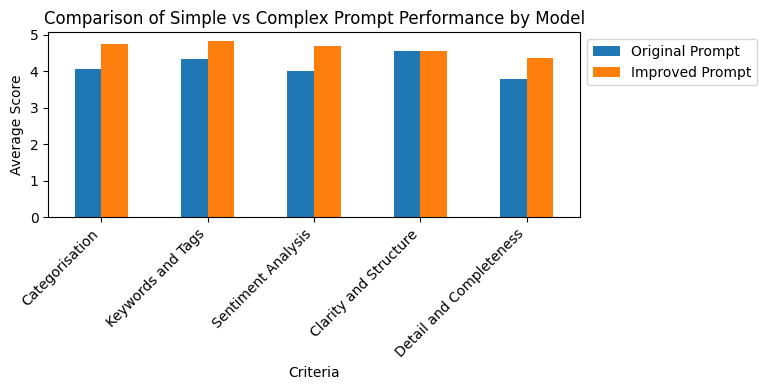

In [12]:
import matplotlib.pyplot as plt

df["simple_scores"] = df["simple_evaluation"].apply(lambda x: [score for key, score in x.model_dump().items() if key != 'justification'])
df["complex_scores"] = df["complex_evaluation"].apply(lambda x: [score for key, score in x.model_dump().items() if key != 'justification'])


# Calculate average scores for each criterion
criteria = [
    'Categorisation',
    'Keywords and Tags',
    'Sentiment Analysis',
    'Clarity and Structure',
    'Detail and Completeness'
]

# Calculate average scores for each criterion by model
simple_avg_scores = df['simple_scores'].apply(pd.Series).mean()
complex_avg_scores = df['complex_scores'].apply(pd.Series).mean()


# Prepare data for plotting
avg_scores_df = pd.DataFrame({
    'Criteria': criteria,
    'Original Prompt': simple_avg_scores,
    'Improved Prompt': complex_avg_scores
})

# Plotting
ax = avg_scores_df.plot(x='Criteria', kind='bar', figsize=(6, 4))
plt.ylabel('Average Score')
plt.title('Comparison of Simple vs Complex Prompt Performance by Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


After evaluating the results, we found that while the basic prompt performed well in clarity and structure, the enhanced prompt significantly improved outputs across several other key criteria: Categorization, Keywords and Tags, Sentiment Analysis, and Detail and Completeness. The complex prompt led to summaries that were more informative, better organized, and richer in content.

This demonstrates how refining prompts can greatly enhance the quality of the generated summaries. Although this is a simplified example, the benefits of prompt optimization are expected to be even more pronounced in real-world, production-level applications, leading to outputs that are more aligned with specific goals and user needs.

## Conclusion

Meta prompting is a powerful technique that can significantly enhance the quality of outputs from language models. Our exploration showed that starting with a simple prompt and refining it using `o1-preview` led to summaries that were more informative, better organized, and richer in content—improving across key criteria like categorization, keywords and tags, sentiment analysis, and completeness. This exercise underscores the value of prompt optimization, and even in this simplified example, the benefits are clear. In real-world applications, leveraging meta prompting and tools like `o1-preview` can elevate language model performance to better meet your specific goals and user needs.